In [9]:
import optuna
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import ARIMA
from utilsforecast.evaluation import evaluate

import warnings
import logging

warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("optuna").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [10]:
# Definir las métricas
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Evaluación de métricas
def evaluate(cv_df, metrics):
    results = {}
    for metric in metrics:
        y_true = cv_df['y'].values
        y_pred = cv_df['ARIMA'].values
        results[metric.__name__] = metric(y_true, y_pred)
    return results

In [11]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [12]:
horizon = 1

In [13]:
# Definir función para optimización por ticker
def optimize_for_ticker(ticker):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    print(f"Number of observations for {ticker}: {len(Y_df_ticker)}")

    if Y_df_ticker['y'].isnull().any():
        print(f"NaN values found in {ticker}.")
        return None, None  # Retorna None para ambos si hay NaN

    # Diccionario para almacenar las métricas
    metrics_dict = {}

    # Definir función objetivo para Optuna
    def objective(trial):
        order = (trial.suggest_int('p', 0, 2), 
                 trial.suggest_int('d', 0, 1), 
                 trial.suggest_int('q', 0, 2))
        seasonal_order = (trial.suggest_int('P', 0, 1), 
                          trial.suggest_int('D', 0, 1), 
                          trial.suggest_int('Q', 0, 1))
        season_length = trial.suggest_int('season_length', 1, min(52, len(Y_df_ticker)))

        # Instanciar el modelo ARIMA
        model = ARIMA(order=order, seasonal_order=seasonal_order, season_length=season_length)

        sf = StatsForecast(df=Y_df_ticker, models=[model], freq='W', n_jobs=-1)

        # Validación cruzada
        cv_df = sf.cross_validation(df=Y_df_ticker, h=horizon, step_size=horizon, n_windows=5).reset_index()

        # Evaluación de las predicciones
        evaluation_results = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[smape, mape, mse, mae, rmse])

        # Guardar las métricas para el análisis posterior
        metrics_dict[trial.number] = {
            'smape': evaluation_results['smape'],
            'mape': evaluation_results['mape'],
            'mse': evaluation_results['mse'],
            'mae': evaluation_results['mae'],
            'rmse': evaluation_results['rmse']
        }

        return evaluation_results['smape']

    # Optimización con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=25)

    best_params = study.best_params
    best_trial = study.best_trial.number

    print(f"Best hyperparameters for {ticker}: {best_params}")
    print(f"Best SMAPE for {ticker}: {study.best_value}")
    print(f"Metrics for the best trial ({best_trial}): {metrics_dict[best_trial]}")

    return best_params, metrics_dict[best_trial]

In [14]:
# Crear modelo y predecir
def create_model_and_predict(ticker, best_params):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    # Crear modelo final con los mejores parámetros
    final_model = ARIMA(
        order=(best_params['p'], best_params['d'], best_params['q']),
        seasonal_order=(best_params['P'], best_params['D'], best_params['Q']),
        season_length=best_params['season_length']
    )

    sf_final = StatsForecast(df=Y_df_ticker, models=[final_model], freq='W', n_jobs=-1)

    prediction_length = len(Y_df_ticker) - horizon
    Y_df_real = Y_df_ticker[:prediction_length]

    sf_final.fit(Y_df_real)
    forecast = sf_final.forecast(h=horizon)

    print(f"Predictions for {ticker}:")
    print(forecast)

    return forecast

In [19]:
def plot_predictions(ticker, forecast):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]
    
    # Graficar
    plt.figure(figsize=(12, 6))

    # Datos reales (históricos)
    real_series = Y_df_ticker[['ds', 'y']]  
    plt.plot(real_series['ds'], real_series['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Predicciones
    forecast_series = forecast[['ds', 'ARIMA']]
    plt.plot(forecast_series['ds'], forecast_series['ARIMA'], label='Prediction', marker='x', color='orange', linestyle='--', linewidth=2)

    # Ampliar la zona de predicción
    plt.axvspan(forecast_series['ds'].min(), forecast_series['ds'].max(), color='orange', alpha=0.1, label='Prediction Range')

    # Configurar el gráfico
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    
    # Focalizar en la zona de predicción: mostrar solo las fechas de predicción
    min_prediction_date = forecast_series['ds'].min() - pd.DateOffset(months=1)  
    max_prediction_date = forecast_series['ds'].max() + pd.DateOffset(months=1) 
    plt.xlim([min_prediction_date, max_prediction_date])

    # Mostrar una cuadrícula
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

In [16]:
# Optimización para cada ticker
best_params_dict = {}
for ticker in tickers:
    print(f"\nOptimizando para {ticker}...")
    best_params, best_metrics = optimize_for_ticker(ticker)
    if best_params is not None:
        best_params_dict[ticker] = best_params


Optimizando para AAPL...
Number of observations for AAPL: 1292
Best hyperparameters for AAPL: {'p': 1, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 1, 'season_length': 26}
Best SMAPE for AAPL: 0.9674482978880405
Metrics for the best trial (15): {'smape': 0.9674482978880405, 'mape': 0.9606440551578999, 'mse': 8.375829, 'mae': 2.173111, 'rmse': 2.8941023}

Optimizando para MSFT...
Number of observations for MSFT: 1292
Best hyperparameters for MSFT: {'p': 2, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 1, 'season_length': 18}
Best SMAPE for MSFT: 3.1574200838804245
Metrics for the best trial (12): {'smape': 3.1574200838804245, 'mape': 3.14108207821846, 'mse': 239.62752, 'mae': 13.217944, 'rmse': 15.479907}

Optimizando para GOOGL...
Number of observations for GOOGL: 1051
Best hyperparameters for GOOGL: {'p': 2, 'd': 0, 'q': 0, 'P': 0, 'D': 1, 'Q': 1, 'season_length': 20}
Best SMAPE for GOOGL: 3.377258777618408
Metrics for the best trial (2): {'smape': 3.377258777618408, 'mape': 3.41867133975029, 'mse': 

In [17]:
# Crear y predecir
import time
forecasts_dict = {}

for ticker in tickers:
    if ticker in best_params_dict:
        print(f"\nCreando el modelo y realizando predicciones para {ticker}...")

        start_time = time.time()
        forecast = create_model_and_predict(ticker, best_params_dict[ticker])
        end_time = time.time()

        print(f"Tiempo de predicción para {ticker}: {end_time - start_time:.2f} segundos")
        forecasts_dict[ticker] = forecast


Creando el modelo y realizando predicciones para AAPL...
Predictions for AAPL:
                  ds       ARIMA
unique_id                       
AAPL      2024-09-22  228.706467
Tiempo de predicción para AAPL: 16.67 segundos

Creando el modelo y realizando predicciones para MSFT...
Predictions for MSFT:
                  ds       ARIMA
unique_id                       
MSFT      2024-09-22  428.580994
Tiempo de predicción para MSFT: 3.45 segundos

Creando el modelo y realizando predicciones para GOOGL...
Predictions for GOOGL:
                  ds       ARIMA
unique_id                       
GOOGL     2024-09-29  163.619568
Tiempo de predicción para GOOGL: 14.91 segundos

Creando el modelo y realizando predicciones para AMZN...
Predictions for AMZN:
                  ds       ARIMA
unique_id                       
AMZN      2024-09-22  189.552078
Tiempo de predicción para AMZN: 10.59 segundos

Creando el modelo y realizando predicciones para NVDA...
Predictions for NVDA:
              


Graficando las predicciones para AAPL...


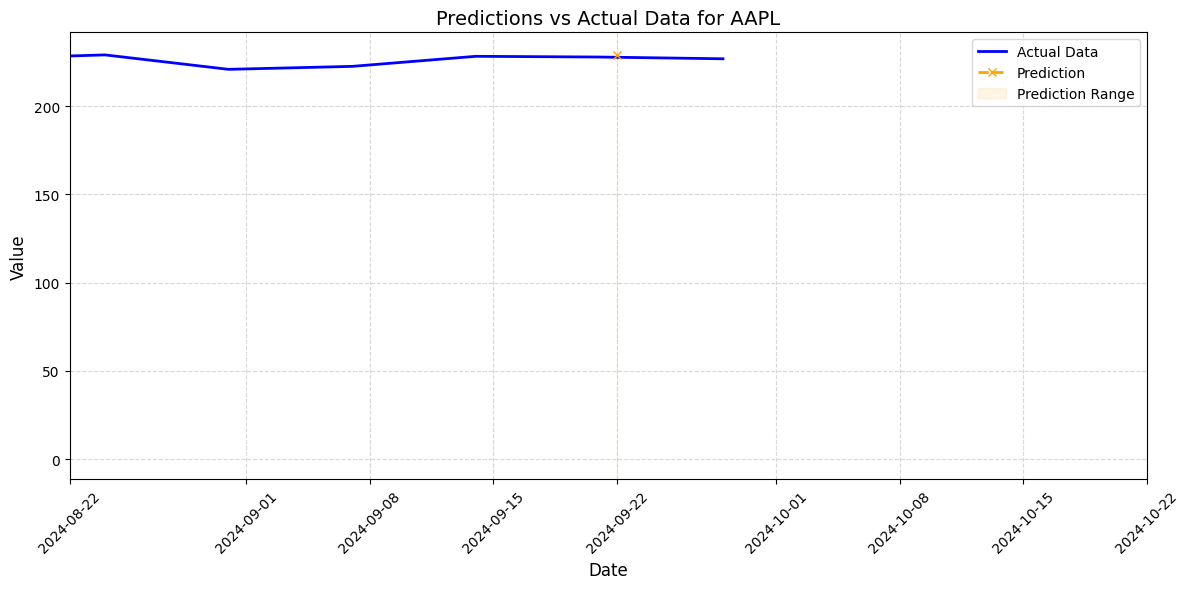


Graficando las predicciones para MSFT...


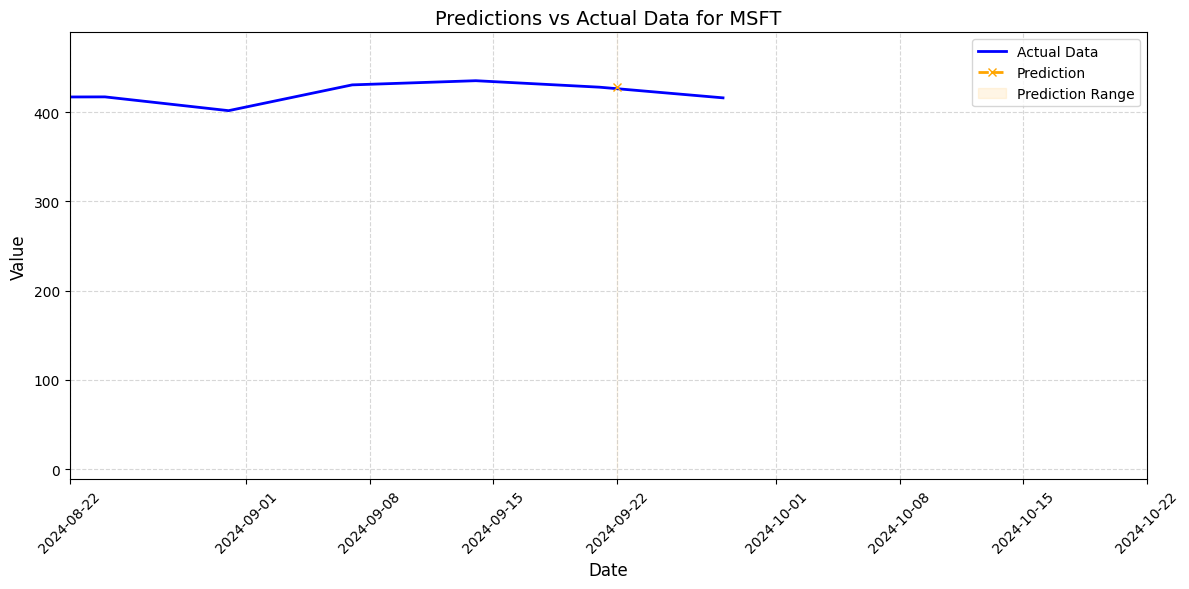


Graficando las predicciones para GOOGL...


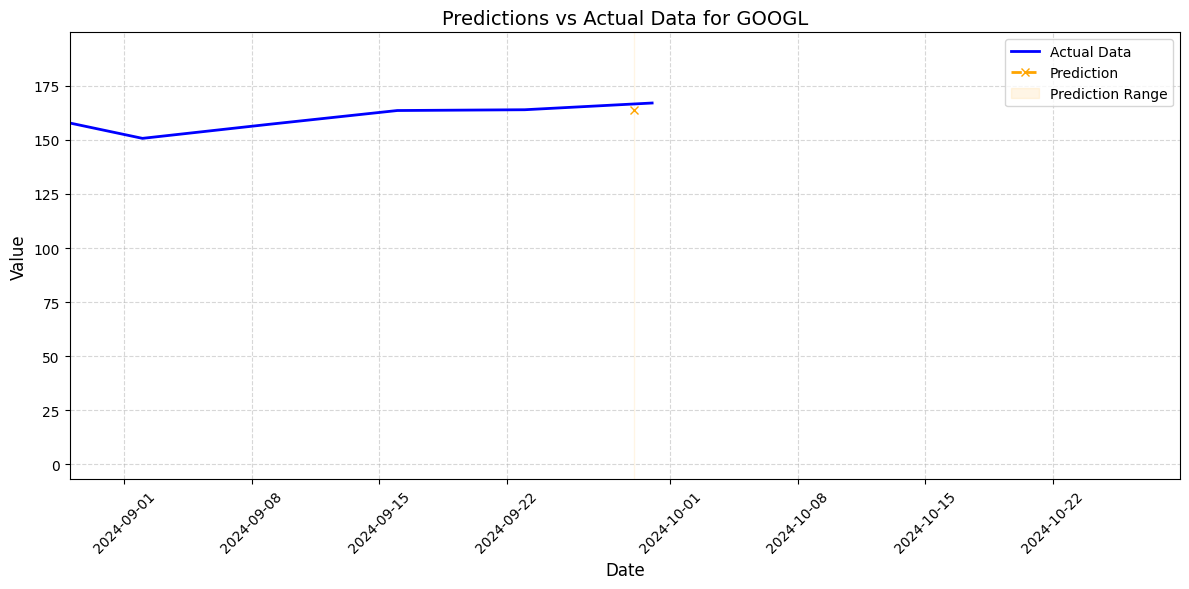


Graficando las predicciones para AMZN...


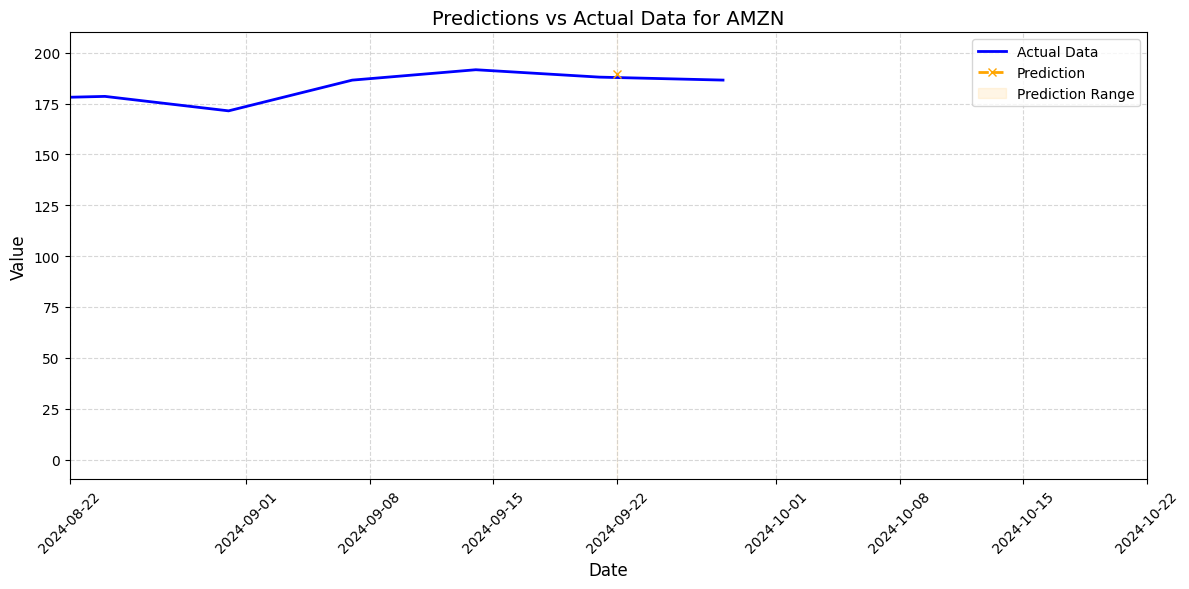


Graficando las predicciones para NVDA...


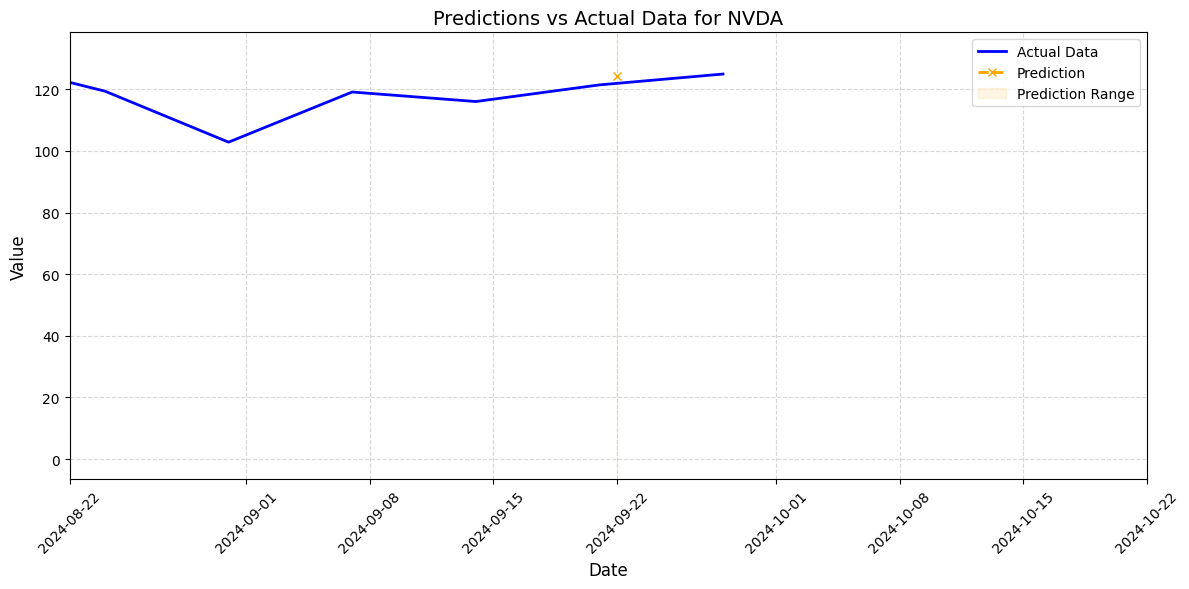


Graficando las predicciones para META...


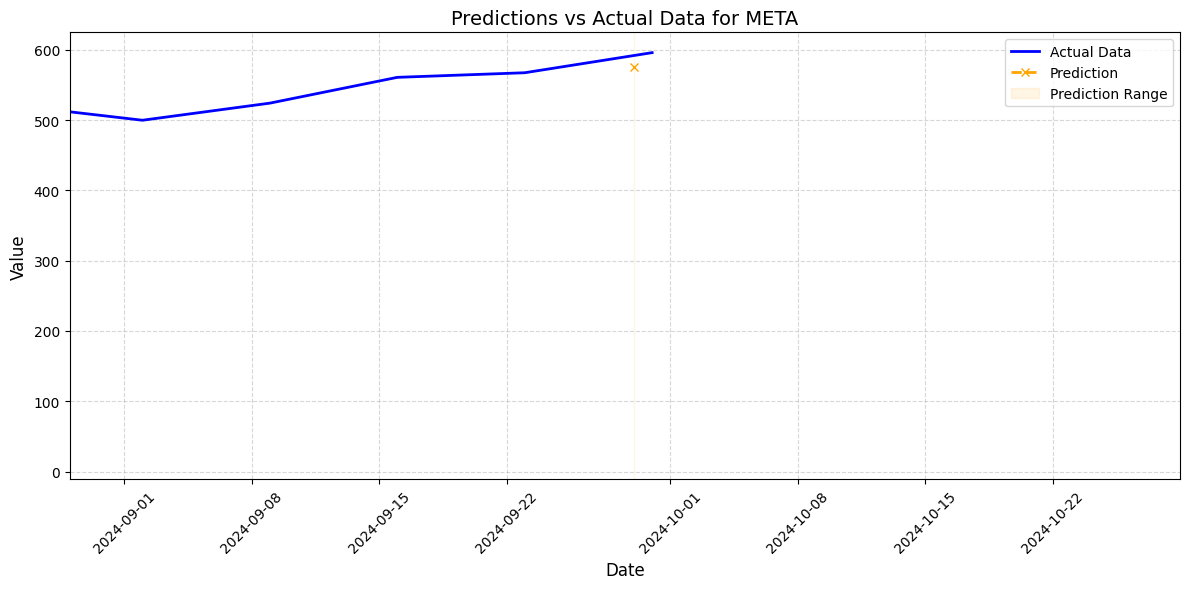


Graficando las predicciones para IBM...


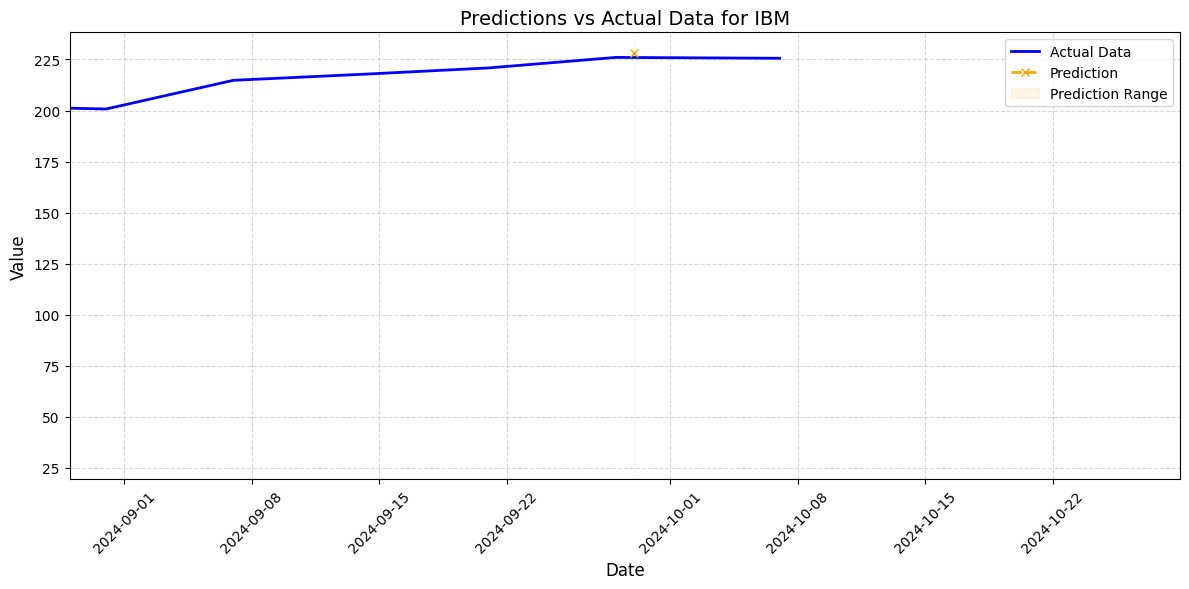


Graficando las predicciones para BTC-USD...


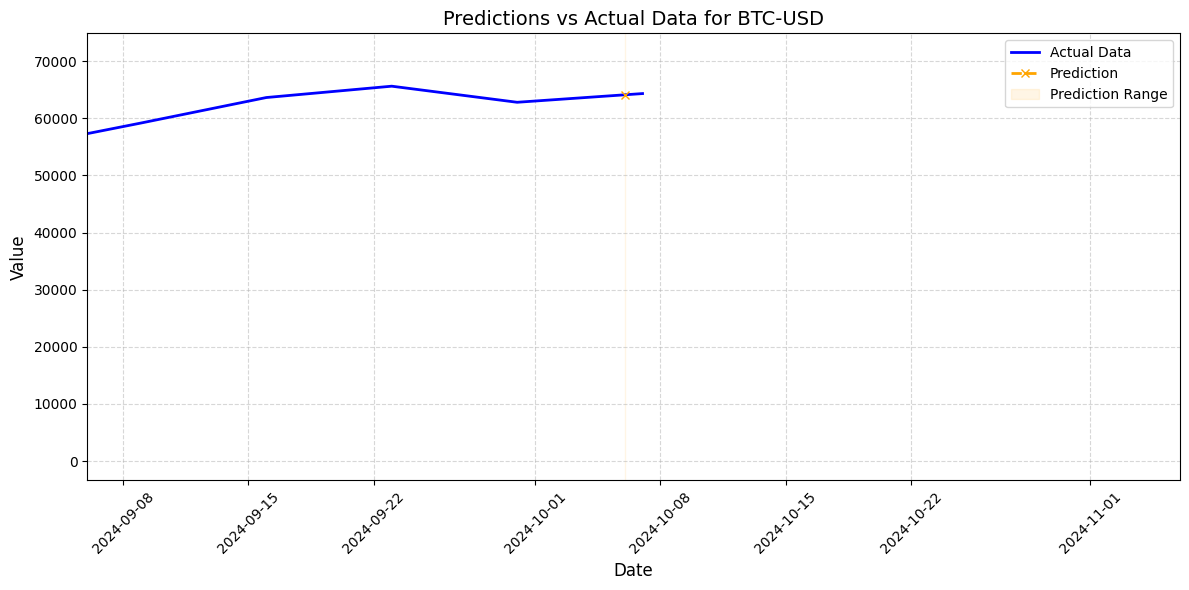

In [20]:
# Graficar resultados
for ticker in forecasts_dict:
    print(f"\nGraficando las predicciones para {ticker}...")
    plot_predictions(ticker, forecasts_dict[ticker])